<a href="https://colab.research.google.com/github/boroju/aidl-upc-winter2024-satellite-imagery/blob/main/notebooks/jose/data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install odc-stac
!pip install planetary_computer
!pip install rioxarray
!pip install 'stackstac[viz]'
!pip install zen3geo
!pip install pyogrio[geopandas]
!pip install xbatcher

In [ ]:
# Geospatial libraries
import pystac
import pystac_client
import planetary_computer
import rioxarray
# Deep Learning libraries
import torch
import torchdata
import zen3geo

In [ ]:
print(f"pystac version: {pystac.__version__}")
print(f"planetary-computer version: {planetary_computer.__version__}")
print(f"torch version: {torch.__version__}")

print(f"torchdata version: {torchdata.__version__}")
print(f"zen3geo version: {zen3geo.__version__}")
rioxarray.show_versions()

pystac version: 1.9.0
planetary-computer version: 1.0.0
torch version: 2.1.0+cu121
torchdata version: 0.7.0
zen3geo version: 0.6.2
rioxarray (0.15.0) deps:
  rasterio: 1.3.9
    xarray: 2023.7.0
      GDAL: 3.6.4
      GEOS: 3.11.1
      PROJ: 9.0.1
 PROJ DATA: /usr/local/lib/python3.10/dist-packages/rasterio/proj_data
 GDAL DATA: /usr/local/lib/python3.10/dist-packages/rasterio/gdal_data

Other python deps:
     scipy: 1.11.4
    pyproj: 3.6.1

System:
    python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
executable: /usr/bin/python3
   machine: Linux-6.1.58+-x86_64-with-glibc2.35


## Find Cloud-Optimized GeoTIFFs

In [ ]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# 2021 Dixie Wildfire in California
latitude = 40.7310
longitude = -122.9420
location = [longitude, latitude]
# area_of_interest or geometry
area_of_interest = {
    "type": "Point",
    "coordinates": location,
}
buffer = 0.7
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]

range = "2021-06-21/2021-06-30"
landcover_search = catalog.search(
    intersects=area_of_interest,
    collections=["sentinel-2-l2a"],
    datetime=range,
    query={"eo:cloud_cover": {"lt": 10}}
)
#items = search.get_all_items()
#print(len(items))

# Check how many items were returned
items = landcover_search.item_collection()
print(f"Returned {len(items)} Items")

from pystac.extensions.eo import EOExtension as eo
least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

Returned 3 Items
Choosing S2B_MSIL2A_20210626T185919_R013_T10TEL_20210627T035058 from 2021-06-26 with 0.115939% cloud cover


In [ ]:
url: str = least_cloudy_item.assets["visual"].href
print(url)

https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/10/T/EL/2021/06/26/S2B_MSIL2A_20210626T185919_N0300_R013_T10TEL_20210627T035058.SAFE/GRANULE/L2A_T10TEL_A022490_20210626T190811/IMG_DATA/R10m/T10TEL_20210626T185919_TCI_10m.tif?st=2024-01-17T18%3A52%3A20Z&se=2024-01-18T19%3A37%3A20Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-01-18T17%3A36%3A44Z&ske=2024-01-25T17%3A36%3A44Z&sks=b&skv=2021-06-08&sig=5Q9Pf63EEQZBOlw6uxJOHJ4BBwZ5zEeJ8dJZXS%2BoNC0%3D


## Inspect one of the data assets

In [ ]:
da = rioxarray.open_rasterio(filename=url)
da

<xarray.DataArray (band: 3, y: 10980, x: 10980)>
[361681200 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05 6.098e+05
  * y            (y) float64 4.6e+06 4.6e+06 4.6e+06 ... 4.49e+06 4.49e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
# Takes time!! Better later settting overview_level
# da.squeeze().plot.imshow()

## 1️⃣ Construct DataPipe 📡

In [ ]:
dp = torchdata.datapipes.iter.IterableWrapper(iterable=[url])
print(dp)
list(dp)

IterableWrapperIterDataPipe


['https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/10/T/EL/2021/06/26/S2B_MSIL2A_20210626T185919_N0300_R013_T10TEL_20210627T035058.SAFE/GRANULE/L2A_T10TEL_A022490_20210626T190811/IMG_DATA/R10m/T10TEL_20210626T185919_TCI_10m.tif?st=2024-01-17T18%3A52%3A20Z&se=2024-01-18T19%3A37%3A20Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-01-18T17%3A36%3A44Z&ske=2024-01-25T17%3A36%3A44Z&sks=b&skv=2021-06-08&sig=5Q9Pf63EEQZBOlw6uxJOHJ4BBwZ5zEeJ8dJZXS%2BoNC0%3D']

The dp variable is the DataPipe! Now to apply some more transformations/functions on it.

In [ ]:
# Using functional form (recommended)
dp_rioxarray = dp.read_from_rioxarray()
print(dp_rioxarray)
list(dp_rioxarray)

RioXarrayReaderIterDataPipe


[StreamWrapper<<xarray.DataArray (band: 3, y: 10980, x: 10980)>
 [361681200 values with dtype=uint8]
 Coordinates:
   * band         (band) int64 1 2 3
   * x            (x) float64 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05 6.098e+05
   * y            (y) float64 4.6e+06 4.6e+06 4.6e+06 ... 4.49e+06 4.49e+06
     spatial_ref  int64 0
 Attributes:
     AREA_OR_POINT:  Area
     _FillValue:     0
     scale_factor:   1.0
     add_offset:     0.0>]

What if you don’t want the whole Sentinel-2 scene at the full 10m resolution? Since we’re using Cloud-Optimized GeoTIFFs, you could set an overview_level (following https://corteva.github.io/rioxarray/stable/examples/COG.html).

In [ ]:
dp_rioxarray_zoom3 = dp.read_from_rioxarray(overview_level=3)
print(dp_rioxarray_zoom3)
list(dp_rioxarray)

RioXarrayReaderIterDataPipe


[StreamWrapper<<xarray.DataArray (band: 3, y: 10980, x: 10980)>
 [361681200 values with dtype=uint8]
 Coordinates:
   * band         (band) int64 1 2 3
   * x            (x) float64 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05 6.098e+05
   * y            (y) float64 4.6e+06 4.6e+06 4.6e+06 ... 4.49e+06 4.49e+06
     spatial_ref  int64 0
 Attributes:
     AREA_OR_POINT:  Area
     _FillValue:     0
     scale_factor:   1.0
     add_offset:     0.0>]

In [ ]:
list(dp_rioxarray_zoom3)[0]

StreamWrapper<<xarray.DataArray (band: 3, y: 687, x: 687)>
[1415907 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5.001e+05 5.002e+05 ... 6.095e+05 6.097e+05
  * y            (y) float64 4.6e+06 4.6e+06 4.6e+06 ... 4.49e+06 4.49e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0>

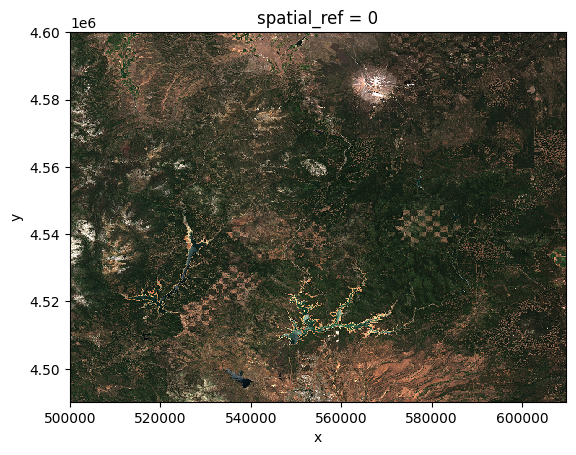

In [ ]:
list(dp_rioxarray_zoom3)[0].astype("int").plot.imshow(rgb="band")

## Into a DataLoader 🏋️

In [ ]:
def fn(da):
    return torch.as_tensor(da.data)

dp_tensor = dp_rioxarray_zoom3.map(fn=fn)
print(dp_tensor)
list(dp_tensor)

MapperIterDataPipe


[tensor([[[ 53,  41,  17,  ...,  38,  34,  18],
          [ 29,  52,  19,  ...,  32,  39,  79],
          [ 33,  21,  43,  ...,  25,  65,  81],
          ...,
          [ 78,  20,  87,  ...,  61,  64,  57],
          [ 35,  49,  83,  ...,  26, 103, 104],
          [ 28,  70,  31,  ...,  29, 106,  55]],
 
         [[ 61,  59,  35,  ...,  37,  34,  23],
          [ 48,  58,  44,  ...,  33,  37,  66],
          [ 54,  43,  58,  ...,  28,  55,  67],
          ...,
          [ 73,  33,  75,  ...,  51,  56,  51],
          [ 47,  54,  76,  ...,  30,  85,  84],
          [ 42,  61,  45,  ...,  33,  86,  47]],
 
         [[ 43,  38,  23,  ...,  29,  27,  18],
          [ 29,  43,  27,  ...,  25,  30,  56],
          [ 35,  26,  38,  ...,  22,  44,  59],
          ...,
          [ 57,  22,  58,  ...,  38,  44,  37],
          [ 34,  41,  58,  ...,  22,  65,  64],
          [ 30,  46,  30,  ...,  23,  68,  35]]], dtype=torch.uint8)]

# Clipping and batching data

## 1️⃣ Creating 512x512 chips from large satellite scenes 🪟

### Slicing with XbatcherSlicer 🍕

In [ ]:
print(dp_rioxarray)
dp_xbatcher = dp_rioxarray.slice_with_xbatcher(input_dims={"y": 512, "x": 512})
print(dp_xbatcher)
print(f"Number of chips: {len(dp_xbatcher)}")

RioXarrayReaderIterDataPipe
XbatcherSlicerIterDataPipe
Number of chips: 441


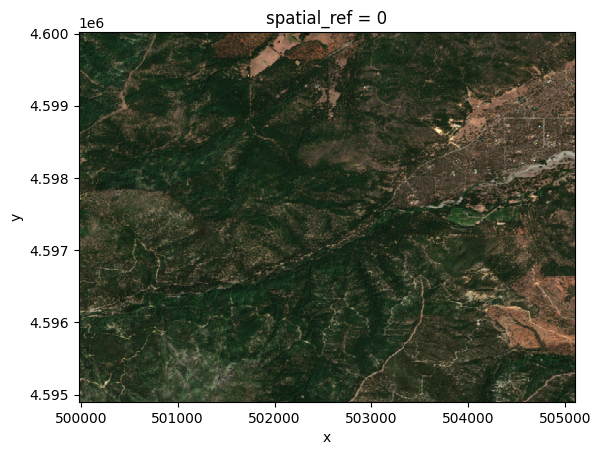

In [ ]:
list(dp_xbatcher)[0].astype("int").plot.imshow(rgb="band")

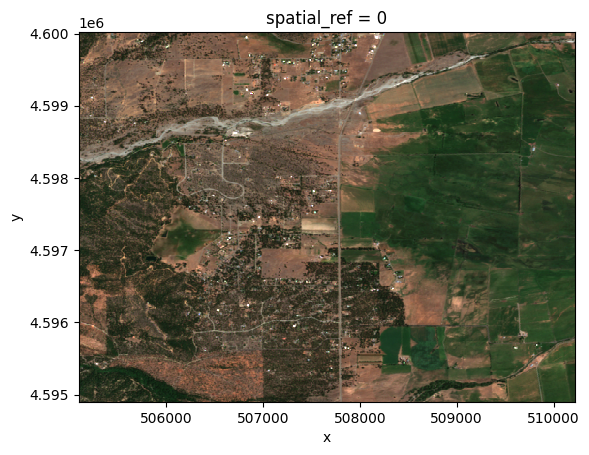

In [ ]:
list(dp_xbatcher)[1].astype("int").plot.imshow(rgb="band")

Now, if you want to customize the sliding window (e.g. do overlapping strides), pass in extra parameters to slice_with_xbatcher, and it will be handled by xbatcher.BatchGenerator.

In [ ]:
dp_xbatcher = dp_rioxarray.slice_with_xbatcher(
        input_dims={"y": 512, "x": 512}, input_overlap={"y": 256, "x": 256}
)
print(dp_xbatcher)
print(f"Number of chips: {len(dp_xbatcher)}")

XbatcherSlicerIterDataPipe
Number of chips: 1681


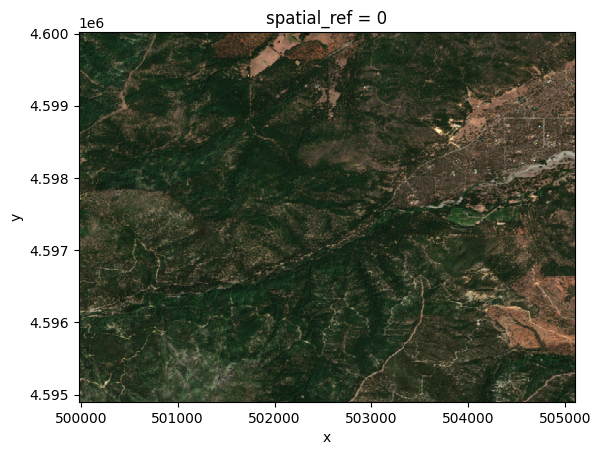

In [ ]:
list(dp_xbatcher)[0].astype("int").plot.imshow(rgb="band")

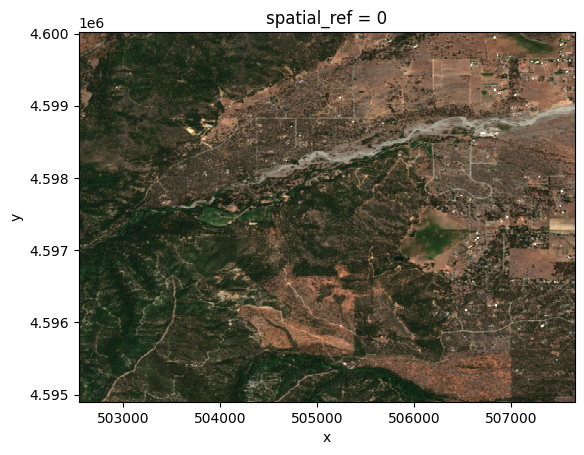

In [ ]:
list(dp_xbatcher)[1].astype("int").plot.imshow(rgb="band")

Double-check that single chips are of the correct dimensions (band: 1, y: 512, x: 512).

In [ ]:
chips = list(dp_xbatcher)
sample = chips[0]
sample

<xarray.DataArray (band: 3, y: 512, x: 512)>
array([[[ 19,  28,  26, ...,  99,  73,  60],
        [ 31,  53,  46, ...,  63,  42,  49],
        [ 25,  39,  39, ...,  47,  42,  42],
        ...,
        [ 79,  71,  65, ...,  47, 107,  90],
        [ 88,  79,  59, ...,  38, 100,  72],
        [ 84,  76,  67, ...,  23,  42,  52]],

       [[ 32,  54,  48, ...,  75,  62,  59],
        [ 47,  68,  57, ...,  53,  51,  52],
        [ 37,  46,  48, ...,  42,  49,  46],
        ...,
        [ 84,  77,  79, ...,  56, 100,  90],
        [ 98,  86,  72, ...,  46,  93,  77],
        [ 92,  80,  79, ...,  44,  54,  59]],

       [[ 21,  28,  27, ...,  55,  46,  40],
        [ 29,  40,  32, ...,  39,  31,  32],
        [ 26,  35,  29, ...,  33,  27,  26],
        ...,
        [ 74,  58,  53, ...,  37,  70,  67],
        [ 80,  74,  48, ...,  33,  66,  58],
        [ 71,  67,  57, ...,  21,  30,  37]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5e+05 5e+05 5e+05 ... 5.051e+05 5.051e+05 5.051e+05
  * y            (y) float64 4.6e+06 4.6e+06 4.6e+06 ... 4.595e+06 4.595e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

Please do not use overlapping strides (i.e. input_overlap < input_dim) if you will be 🪓 splitting your chips into training, validation and test sets later! If you have say 60 overlapping chips and then go on to divide those 🍪 chips randomly into train/val/test sets of 30/20/10, you will have information leakage 🚰 between the 30 training chips and 20 validation plus 10 test chips, so your model’s reported validation and test metrics 📈 will be overestimating the actual performance 😲!

Ideally, your train/val/test chips should be situated independently within spatially contiguous blocks 🧱

## 2️⃣ Pool chips into mini-batches ⚙️

In [ ]:
dp_batch = dp_xbatcher.batch(batch_size=10)
print(f"Number of items in first batch: {len(list(dp_batch)[0])}")

Number of items in first batch: 10


Now each batch will have 10 chips of size 512 x 512, with each chip being an xarray.DataArray.

**Notice how no mosaicking nor reprojection was done for the two satellite scenes. This is the beauty of zen3geo - full flexibility of combining geospatial datasets 😎. Respect the native coordinate system and let the data flow directly into your models!**

### Stack many chips in mini-batches into a single tensor 🥞

Let’s now stack all these chips into a single tensor per batch, with a (number, channel, height, width) shape like (10, 3, 512, 512).

In [ ]:
def xr_collate_fn(samples) -> torch.Tensor:
    """
    Converts individual xarray.DataArray objects to a torch.Tensor (int16
    dtype), and stacks them all into a single torch.Tensor.
    """
    tensors = [
        torch.as_tensor(data=sample.data.astype(dtype="int16")) for sample in samples
    ]
    return torch.stack(tensors=tensors)

dp_collate = dp_batch.collate(collate_fn=xr_collate_fn)
print(dp_collate)
print(f"Number of mini-batches: {len(dp_collate)}")
print(f"Mini-batch tensor shape: {list(dp_collate)[0].shape}")

CollatorIterDataPipe
Number of mini-batches: 169
Mini-batch tensor shape: torch.Size([10, 3, 512, 512])


### Into a DataLoader 🏋️

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset=dp_collate, batch_size=None)
for i, batch in enumerate(dataloader):
    tensor = batch
    print(f"Batch {i}: {tensor.shape}")

Batch 0: torch.Size([10, 3, 512, 512])
Batch 1: torch.Size([10, 3, 512, 512])
Batch 2: torch.Size([10, 3, 512, 512])
Batch 3: torch.Size([10, 3, 512, 512])
Batch 4: torch.Size([10, 3, 512, 512])
Batch 5: torch.Size([10, 3, 512, 512])
Batch 6: torch.Size([10, 3, 512, 512])
Batch 7: torch.Size([10, 3, 512, 512])
Batch 8: torch.Size([10, 3, 512, 512])
Batch 9: torch.Size([10, 3, 512, 512])
Batch 10: torch.Size([10, 3, 512, 512])
Batch 11: torch.Size([10, 3, 512, 512])
Batch 12: torch.Size([10, 3, 512, 512])
Batch 13: torch.Size([10, 3, 512, 512])
Batch 14: torch.Size([10, 3, 512, 512])
Batch 15: torch.Size([10, 3, 512, 512])
Batch 16: torch.Size([10, 3, 512, 512])
Batch 17: torch.Size([10, 3, 512, 512])
Batch 18: torch.Size([10, 3, 512, 512])
Batch 19: torch.Size([10, 3, 512, 512])
Batch 20: torch.Size([10, 3, 512, 512])
Batch 21: torch.Size([10, 3, 512, 512])
Batch 22: torch.Size([10, 3, 512, 512])
Batch 23: torch.Size([10, 3, 512, 512])
Batch 24: torch.Size([10, 3, 512, 512])
Batch 25: 

Let’s take a look at a graph of the complete data pipeline.

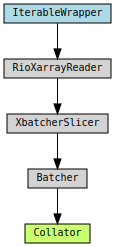

In [ ]:
torchdata.datapipes.utils.to_graph(dp=dp_collate)
